In [ ]:
# !pip install tf-nightly

In [ ]:
!pip install imblearn

In [3]:
import os

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Add, Softmax, Multiply, Concatenate
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import imblearn

# from keras.utils.data_utils import Sequence
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.keras import balanced_batch_generator
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [4]:
tf.__version__

'2.2.0'

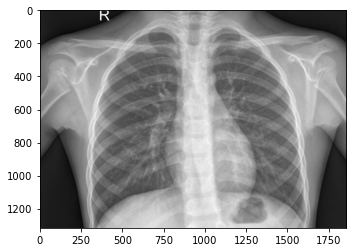

(1317, 1857, 3)

In [5]:
image = cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
plt.imshow(image)
plt.show()
image.shape

In [6]:

class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [7]:
#We can observe from the image that we dont need to read rgb so we'll read grayscale images
train_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
test_generator = ImageDataGenerator(rescale=1./255)

In [8]:
WIDTH, HEIGHT = 256, 256
BATCH_SIZE = 8
train = MixupImageDataGenerator(generator=train_generator,
                                          directory='../input/chest-xray-pneumonia/chest_xray/train',
                                          batch_size=BATCH_SIZE,
                                          img_height=HEIGHT,
                                          img_width=WIDTH,
                                          subset='training')
# val = input_imgen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/val',
#                                                        target_size=(
#                                                            HEIGHT, WIDTH),
#                                                        class_mode="categorical",
#                                                        batch_size=batch_size,
#                                                        shuffle=True,
#                                                        subset='validation')

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [9]:

# train = train_generator.flow_from_directory(
#     '../input/chest-xray-pneumonia/chest_xray/train',
#     target_size=(HEIGHT, WIDTH),
#     class_mode="binary",
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed=99,
# )
test = test_generator.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/test',
    target_size=(HEIGHT, WIDTH),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=99,
)
val = test_generator.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/val',
    target_size=(HEIGHT, WIDTH),
    class_mode="binary",
    batch_size=16,
    shuffle=True,
    seed=99,
)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
print(val.next()[1].shape)
print(BATCH_SIZE)

(16,)
8


In [11]:
# labels = []
# for i in range(652):
#     X,y = train.next()
#     y_int = y.astype('int64')
#     labels = np.concatenate([labels,y_int])
    
# unique, counts = np.unique(labels, return_counts=True)
# neg, pos = counts[0], counts[1]
# total = neg + pos
# print(f'Examples:\n    Total: {total}\n    Positive: {pos} ({100 * pos / total}% of total) Negative: {neg} ({100 * neg / total}% of total)\n')
# # plt.hist(labels)

Building our resnet by creating 2 types of blocks, only difference between conv block and identity block is conv block passes the skip connection through a conv2d layer to match its shape with the next resnet block.
Code for resnet is a modified version of Priya Dwivedi's resnet architecture - https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb[]
We will convert this Resnet 50 into an Attention Gated CNN.

In [12]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [13]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X


In [14]:
def GridAttention(l, g, l_features, g_features, attention_features, scale_factor, blockno, mechanism):
    _l = Conv2D(attention_features, (1,1), use_bias=False)(l)
    _g = UpSampling2D(scale_factor)(g)
    _g = Conv2D(attention_features, (1,1), use_bias=False)(_g)
    X = Add()([_l, _g])
    X = Activation('relu')(X)
    X = Conv2D(1, (1,1), use_bias=True)(X)
    if mechanism.lower() == 'sigmoid':
        X = Activation('sigmoid', name='sigmoid'+str(blockno))(X)
    elif mechanism.lower() == 'softmax':
        X = Softmax()(X)
    X = Multiply()([X, _l])
    if mechanism.lower() == 'softmax':
        X = tf.reduce_sum(tf.reshape(X, (BATCH_SIZE, attention_features, -1)), axis=-1)
    elif mechanism.lower() == 'sigmoid':
        X = GlobalAveragePooling2D()(X)
    return X

In [15]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Start phase
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)

    # Stage 1
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=1, block='b')
    stage1 = identity_block(X, 3, [64, 64, 256], stage=1, block='c')
#     stage1 = MaxPooling2D((2,2), name='maxpool1')(X)

    # Stage 2 (≈4 lines)
    X = convolutional_block(stage1, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=2, block='c')
    stage2 = identity_block(X, 3, [128, 128, 512], stage=2, block='d')
#     stage2 = MaxPooling2D((2,2), name='maxpool2')(X)
    
    # Stage 3 (≈6 lines)
    X = convolutional_block(stage2, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='e')
    stage3 = identity_block(X, 3, [256, 256, 1024], stage=3, block='f')
#     stage3 = MaxPooling2D((2,2), name='maxpool3')(X)

    # Stage 4 (≈3 lines)
    X = convolutional_block(stage3, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=4, block='b')
    stage4 = identity_block(X, 3, [512, 512, 2048], stage=4, block='c')
    pooled = GlobalAveragePooling2D()(stage4)
    
    scale_factor1 = int(stage1.shape[-2]/stage4.shape[-2])
    scale_factor2 = int(stage2.shape[-2]/stage4.shape[-2])
    scale_factor3 = int(stage3.shape[-2]/stage4.shape[-2])
    attn1 = GridAttention(stage1, stage4, stage1.shape[-1], stage4.shape[-1], stage1.shape[-1], scale_factor1, 1, 'sigmoid')
    attn2 = GridAttention(stage2, stage4, stage2.shape[-1], stage4.shape[-1], stage2.shape[-1], scale_factor2, 2, 'sigmoid')
    attn3 = GridAttention(stage3, stage4, stage3.shape[-1], stage4.shape[-1], stage3.shape[-1], scale_factor3, 3, 'sigmoid')
    
    X = Concatenate()([attn1, attn2, attn3, pooled])
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#     X = AveragePooling2D((2,2), name="avg_pool")(stage5)

    ### END CODE HERE ###

    # output layer
    X = keras.layers.Dense(4096, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    X = keras.layers.Dense(4096, activation='relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [16]:
resnet50 = ResNet50(input_shape = (WIDTH, HEIGHT, 3), classes = 2)
# for layer in resnet50.layers:
#     print(layer.trainable)
# g1 = torch.sum(g_conv1.view(batch_size, fsizes[0], -1), dim=-1)

In [17]:
tf.keras.utils.plot_model(resnet50, show_shapes=True)


In [18]:
# resnet50 = tf.keras.applications.ResNet152(
#     include_top=False,
#     weights=None,
#     input_shape=(HEIGHT,WIDTH,1),
#     pooling='max',
# )
# # resnet50.trainable=True

# x = resnet50.output
# x = keras.layers.Dense(4096)(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(4096)(x)
# x = keras.layers.Dropout(0.5)(x)
# predictions = keras.layers.Dense(1, activation='sigmoid')(x)
# resnet50 = keras.models.Model(inputs = resnet50.input, outputs = predictions)
# resnet50.summary()
# # [i.trainable for i in resnet50.layers]

In [19]:
# resnet50.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='resnet50.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
early_stopping_monitor = keras.callbacks.EarlyStopping(patience = 3, monitor = "val_acc", mode="max", verbose = 2)


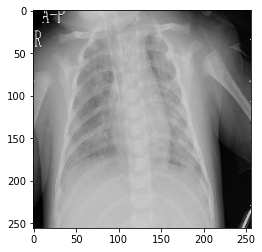

In [22]:
input_image = np.expand_dims(val.next()[0][0], axis =0)
plt.imshow(np.squeeze(input_image))

In [ ]:
lr = 1e-4
decay = 0.01
epochs = 10
# class_weights = {0:100 * pos // total,
#                 1:100 * neg // total}
train_loss_log, val_loss_log, train_accuracy_log, val_accuracy_log = [], [], [], []
adam = keras.optimizers.Adam(lr=lr)
resnet50.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])
for epoch in tqdm(range(epochs)):
    epoch_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    epoch_acc = tf.keras.metrics.Mean()

    epoch_accuracy = tf.keras.metrics.BinaryAccuracy()
#     val_accuracy = tf.keras.metrics.BinaryAccuracy()

    loss_step = tf.keras.losses.binary_crossentropy
    count = 0
    iterator = tqdm(train)
    for data in iterator:
        if count >= 652:
            iterator.close()
            break
        count += 1
        X, y = data
        cw = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
        if len(np.unique(y))>1:
            class_weights = {np.unique(y)[0]:cw[0], np.unique(y)[1]:cw[1]}
            loss,acc = resnet50.train_on_batch(X,y, class_weight=class_weights)
            epoch_acc.update_state(acc)
            epoch_loss.update_state(loss)
        """
            breakpoint()
            with tf.GradientTape() as tape:
                y_hat = resnet50(X, training = True)
                loss = loss_step(y, y_hat)

            gradients = tape.gradient(loss, resnet50.trainable_variables)
            adam.apply_gradients(zip(gradients, resnet50.trainable_variables))
        """
        print(f'Batches seen = {count}, Loss = {epoch_loss.result()}, Accuracy = {epoch_acc.result()}, LR = {lr}     ', end='\r')
    #Apply decay to learning rate after training for 1 epoch
    lr = lr/(1+decay)

    X, y = val.next()
#         breakpoint()
    y_hat = resnet50(X, training = False)
    val_accuracy.update_state(y, y_hat)
    train_loss_log.append(epoch_loss.result())
    train_accuracy_log.append(epoch_acc.result())
    loss = loss_step(y, y_hat)
    val_loss.update_state(loss)
    train_loss_log.append(epoch_loss.result())
    train_accuracy_log.append(epoch_acc.result())
    val_loss_log.append(val_loss.result())
    val_accuracy_log.append(val_accuracy.result())
    
    print(f'Validation Loss = {val_loss.result()}, Validation Accuracy = {val_accuracy.result()}', end='\r')


In [ ]:
resnet50.summary()

In [ ]:
temp_model1 = Model(inputs = resnet50.input, outputs = [resnet50.get_layer('sigmoid1').output], name='sigmoid_check')
temp_model2 = Model(inputs = resnet50.input, outputs = [resnet50.get_layer('sigmoid2').output], name='sigmoid_check')
temp_model3 = Model(inputs = resnet50.input, outputs = [resnet50.get_layer('sigmoid3').output], name='sigmoid_check')


In [ ]:
input_image = np.expand_dims(val.next()[0][0], axis =0)
act1 = temp_model1(input_image)
act2 = temp_model2(input_image)
act3 = temp_model3(input_image)

In [ ]:
%matplotlib inline
fig, axs = plt.subplot(2,2)
plt.imshow(np.squeeze(input_image))
plt.show()
plt.imshow(np.squeeze(act1[0]), cmap='hot')
plt.show()
plt.imshow(np.squeeze(act2[0]), cmap='hot')
plt.show()
plt.imshow(np.squeeze(act3[0]), cmap='hot')

plt.show()

In [ ]:
history = resnet50.fit(train, epochs=10, validation_data=val, callbacks=[reduce_lr, early_stopping_monitor, model_checkpoint])

In [ ]:
resnet50.save('resnetv2_nostart.h5')

In [ ]:
results = resnet50.evaluate(test)

In [ ]:
print(f'Loss = {results[0]}, Accuracy = {results[1]}')